# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups 
Sample_012  Q9GZP0            14.108
Sample_102  P40121;P40121-2   14.171
Sample_075  Q01995            16.081
Sample_173  Q10469            15.187
Sample_159  Q5T848            16.727
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups                 
Sample_108  Q9NQS3;Q9NQS3-2;Q9NQS3-3          14.301
Sample_058  C9JIZ6;P07602;P07602-2;P07602-3   19.580
Sample_038  O14745                            10.393
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.600
            A0A075B6Q5                 13.077
            A0A075B6R2                 13.489
            A0A075B6S5                 13.104
            A0A087WSY4                 13.405
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   11.580
            Q9UI40;Q9UI40-2            11.959
            Q9UIW2                     11.706
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.625
            Q9UP79                     13.169
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.164,15.050,16.842,19.863,16.160,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.595,19.067,...,15.528,15.576,14.544,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.932,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.986,17.705,17.039,15.796,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.902,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,15.082,15.345,17.084,18.708,14.249,19.433,11.697,11.412
Sample_207,15.739,16.877,15.469,16.898,14.440,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.238,12.503,13.069,13.098,13.432,13.483,12.403,12.299,12.644,13.106
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.540,19.067,16.127,...,11.262,13.218,12.591,12.975,13.307,12.788,12.222,12.435,13.510,13.393
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,11.781,12.551,12.863,11.442,12.803,12.674,12.808,13.354,14.237,12.984
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.588,12.991,13.415,12.258,13.542,12.787,12.086,14.049,13.253,12.825
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,14.780,13.004,13.480,12.550,11.864,13.777,13.180,11.918,12.842,13.297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,11.482,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 315.46it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.27it/s]

100%|██████████| 2/2 [00:00<00:00,  7.22it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.78it/s]

100%|██████████| 3/3 [00:00<00:00,  3.51it/s]

100%|██████████| 3/3 [00:00<00:00,  3.80it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.01it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.03it/s]

100%|██████████| 4/4 [00:01<00:00,  3.68it/s]

100%|██████████| 4/4 [00:01<00:00,  3.97it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.39it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.65it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.20it/s]

100%|██████████| 5/5 [00:01<00:00,  3.89it/s]

100%|██████████| 5/5 [00:01<00:00,  4.28it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.03it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.92it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  3.73it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.13it/s]

100%|██████████| 6/6 [00:01<00:00,  2.99it/s]

100%|██████████| 6/6 [00:01<00:00,  3.44it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.12it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.41it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.21it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.10it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.18it/s]

100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

100%|██████████| 7/7 [00:02<00:00,  3.38it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  8.30it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.45it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.35it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.03it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.96it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.75it/s]

100%|██████████| 8/8 [00:01<00:00,  3.68it/s]

100%|██████████| 8/8 [00:01<00:00,  4.11it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.32it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.77it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.42it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.93it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.69it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.60it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.86it/s]

100%|██████████| 9/9 [00:02<00:00,  3.99it/s]

100%|██████████| 9/9 [00:02<00:00,  4.08it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  9.08it/s]

 30%|███       | 3/10 [00:00<00:00,  7.33it/s]

 40%|████      | 4/10 [00:00<00:00,  6.45it/s]

 50%|█████     | 5/10 [00:00<00:00,  5.89it/s]

 60%|██████    | 6/10 [00:00<00:00,  5.34it/s]

 70%|███████   | 7/10 [00:01<00:00,  5.16it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.34it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.18it/s]

100%|██████████| 10/10 [00:01<00:00,  4.32it/s]

100%|██████████| 10/10 [00:01<00:00,  5.02it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.94it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.95it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.06it/s]

 45%|████▌     | 5/11 [00:00<00:01,  4.81it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.85it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.64it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.22it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  3.91it/s]

 91%|█████████ | 10/11 [00:02<00:00,  4.00it/s]

100%|██████████| 11/11 [00:02<00:00,  4.22it/s]

100%|██████████| 11/11 [00:02<00:00,  4.55it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.64it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.56it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.06it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.58it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.58it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.49it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.91it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  4.01it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.09it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.36it/s]

100%|██████████| 12/12 [00:02<00:00,  4.52it/s]

100%|██████████| 12/12 [00:02<00:00,  4.52it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  9.43it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.95it/s]

 31%|███       | 4/13 [00:00<00:02,  4.49it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.59it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.55it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.62it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.53it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.76it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.90it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.05it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.36it/s]

100%|██████████| 13/13 [00:03<00:00,  4.31it/s]

100%|██████████| 13/13 [00:03<00:00,  4.15it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  9.16it/s]

 21%|██▏       | 3/14 [00:00<00:01,  6.22it/s]

 29%|██▊       | 4/14 [00:00<00:01,  5.43it/s]

 36%|███▌      | 5/14 [00:00<00:01,  4.92it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.34it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.33it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.14it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.72it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.76it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.84it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  3.79it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.92it/s]

100%|██████████| 14/14 [00:03<00:00,  4.19it/s]

100%|██████████| 14/14 [00:03<00:00,  4.32it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  9.44it/s]

 20%|██        | 3/15 [00:00<00:01,  6.67it/s]

 27%|██▋       | 4/15 [00:00<00:01,  5.61it/s]

 33%|███▎      | 5/15 [00:00<00:01,  5.06it/s]

 40%|████      | 6/15 [00:01<00:01,  4.81it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.79it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.27it/s]

 60%|██████    | 9/15 [00:01<00:01,  4.27it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.80it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.77it/s]

 80%|████████  | 12/15 [00:02<00:00,  3.67it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  3.89it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.93it/s]

100%|██████████| 15/15 [00:03<00:00,  4.19it/s]

100%|██████████| 15/15 [00:03<00:00,  4.40it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.050 0.021          0.872 0.210       0.156   
2             0.005 0.004      0.051 0.020          0.682 0.103       0.577   
3             0.004 0.002      0.044 0.015          0.776 0.087       0.735   
4             0.006 0.007      0.057 0.023          0.776 0.091       0.714   
5             0.005 0.004      0.055 0.023          0.771 0.087       0.720   
6             0.005 0.004      0.046 0.016          0.769 0.092       0.751   
7             0.005 0.005      0.056 0.025          0.760 0.093       0.733   
8             0.006 0.005      0.057 0.021          0.755 0.092       0.732   
9             0.004 0.001      0.040 0.013          0.775 0.100       0.765   
10            0.004 0.002      0.039 0.012          0.798 0.086       0.805   
11            0.003 0.000      0.036 0.008          0.813 0.085       0.811   
12            0.003 0.001      0.038 0.011          0.838 0.079       0.834   
13            0.004 0.003      0.037 0.010          0.837 0.080       0.837   
14            0.004 0.000      0.038 0.014          0.837 0.081       0.833   
15            0.003 0.001      0.033 0.009          0.830 0.087       0.825   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.087   0.256 0.125                  0.570 0.043        0.868   
2          0.115   0.617 0.089                  0.686 0.067        0.736   
3          0.108   0.749 0.072                  0.787 0.059        0.876   
4          0.102   0.737 0.067                  0.778 0.057        0.870   
5          0.108   0.738 0.068                  0.779 0.055        0.873   
6          0.110   0.755 0.077                  0.791 0.063        0.889   
7          0.109   0.740 0.073                  0.779 0.059        0.886   
8          0.113   0.738 0.077                  0.777 0.061        0.884   
9          0.105   0.764 0.075                  0.798 0.063        0.895   
10         0.110   0.796 0.073                  0.826 0.061        0.910   
11         0.107   0.807 0.074                  0.835 0.062        0.914   
12         0.095   0.832 0.064                  0.857 0.055        0.923   
13         0.092   0.833 0.060                  0.857 0.051        0.922   
14         0.097   0.830 0.064                  0.855 0.054        0.921   
15         0.095   0.823 0.067                  0.849 0.057        0.919   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.832 0.087        210.000 0.000  
2          0.091                  0.724 0.083        210.000 0.000  
3          0.058                  0.837 0.068        210.000 0.000  
4          0.055                  0.830 0.063        210.000 0.000  
5          0.055                  0.834 0.065        210.000 0.000  
6          0.050                  0.870 0.056        210.000 0.000  
7          0.050                  0.869 0.054        210.000 0.000  
8          0.051                  0.866 0.057        210.000 0.000  
9          0.050                  0.882 0.052        210.000 0.000  
10         0.048                  0.897 0.049        210.000 0.000  
11         0.047                  0.902 0.048        210.000 0.000  
12         0.046                  0.914 0.046        210.000 0.000  
13         0.047                  0.913 0.046        210.000 0.000  
14         0.047                  0.912 0.047        210.000 0.000  
15         0.048                  0.909 0.048 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 551.45it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  8.29it/s]

100%|██████████| 2/2 [00:00<00:00,  8.26it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.07it/s]

100%|██████████| 3/3 [00:00<00:00,  4.72it/s]

100%|██████████| 3/3 [00:00<00:00,  5.03it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.78it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.54it/s]

100%|██████████| 4/4 [00:01<00:00,  3.32it/s]

100%|██████████| 4/4 [00:01<00:00,  3.52it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.50it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.21it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.81it/s]

100%|██████████| 5/5 [00:01<00:00,  3.80it/s]

100%|██████████| 5/5 [00:01<00:00,  4.21it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.77it/s]

 50%|█████     | 3/6 [00:00<00:00,  6.04it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  5.08it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  5.24it/s]

100%|██████████| 6/6 [00:01<00:00,  4.88it/s]

100%|██████████| 6/6 [00:01<00:00,  5.27it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.47it/s]

 43%|████▎     | 3/7 [00:00<00:00,  6.28it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  5.38it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  5.61it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  5.41it/s]

100%|██████████| 7/7 [00:01<00:00,  4.91it/s]

100%|██████████| 7/7 [00:01<00:00,  5.43it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.93it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.65it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.76it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.24it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.12it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.15it/s]

100%|██████████| 8/8 [00:01<00:00,  4.09it/s]

100%|██████████| 8/8 [00:01<00:00,  4.45it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.43it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.67it/s]

 44%|████▍     | 4/9 [00:00<00:00,  5.16it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  4.75it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.38it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.15it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.17it/s]

100%|██████████| 9/9 [00:01<00:00,  4.20it/s]

100%|██████████| 9/9 [00:01<00:00,  4.56it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 12.04it/s]

 40%|████      | 4/10 [00:00<00:00,  7.24it/s]

 50%|█████     | 5/10 [00:00<00:00,  6.55it/s]

 60%|██████    | 6/10 [00:00<00:00,  6.50it/s]

 70%|███████   | 7/10 [00:01<00:00,  5.80it/s]

 80%|████████  | 8/10 [00:01<00:00,  5.32it/s]

 90%|█████████ | 9/10 [00:01<00:00,  5.36it/s]

100%|██████████| 10/10 [00:01<00:00,  5.09it/s]

100%|██████████| 10/10 [00:01<00:00,  5.86it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00,  9.05it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.94it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.16it/s]

 45%|████▌     | 5/11 [00:00<00:01,  4.46it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.44it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.34it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.21it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  4.00it/s]

 91%|█████████ | 10/11 [00:02<00:00,  4.02it/s]

100%|██████████| 11/11 [00:02<00:00,  4.22it/s]

100%|██████████| 11/11 [00:02<00:00,  4.50it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 10.61it/s]

 33%|███▎      | 4/12 [00:00<00:01,  7.42it/s]

 42%|████▏     | 5/12 [00:00<00:01,  6.43it/s]

 50%|█████     | 6/12 [00:00<00:00,  6.04it/s]

 58%|█████▊    | 7/12 [00:01<00:00,  5.69it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  5.20it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  5.21it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  5.11it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  4.94it/s]

100%|██████████| 12/12 [00:02<00:00,  5.04it/s]

100%|██████████| 12/12 [00:02<00:00,  5.60it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 13.67it/s]

 31%|███       | 4/13 [00:00<00:01,  7.91it/s]

 38%|███▊      | 5/13 [00:00<00:01,  7.49it/s]

 46%|████▌     | 6/13 [00:00<00:00,  7.42it/s]

 54%|█████▍    | 7/13 [00:00<00:00,  7.01it/s]

 62%|██████▏   | 8/13 [00:01<00:00,  6.67it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  7.11it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  7.35it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  7.52it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  7.77it/s]

100%|██████████| 13/13 [00:01<00:00,  7.53it/s]

100%|██████████| 13/13 [00:01<00:00,  7.55it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01, 11.29it/s]

 29%|██▊       | 4/14 [00:00<00:01,  6.53it/s]

 36%|███▌      | 5/14 [00:00<00:01,  6.40it/s]

 43%|████▎     | 6/14 [00:00<00:01,  5.91it/s]

 50%|█████     | 7/14 [00:01<00:01,  6.02it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  5.48it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  5.29it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  5.10it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  5.41it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  5.67it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  5.84it/s]

100%|██████████| 14/14 [00:02<00:00,  5.96it/s]

100%|██████████| 14/14 [00:02<00:00,  5.91it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 15.83it/s]

 27%|██▋       | 4/15 [00:00<00:01, 10.57it/s]

 40%|████      | 6/15 [00:00<00:00,  9.55it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  8.94it/s]

 60%|██████    | 9/15 [00:00<00:00,  8.80it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.71it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  8.57it/s]

 80%|████████  | 12/15 [00:01<00:00,  8.59it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  8.62it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  8.61it/s]

100%|██████████| 15/15 [00:01<00:00,  8.53it/s]

100%|██████████| 15/15 [00:01<00:00,  9.00it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.002      0.036 0.009          0.067 0.233       0.007   
2             0.006 0.007      0.050 0.026          0.671 0.283       0.205   
3             0.005 0.005      0.054 0.026          0.798 0.076       0.708   
4             0.006 0.005      0.053 0.023          0.796 0.083       0.708   
5             0.003 0.001      0.025 0.008          0.789 0.072       0.717   
6             0.002 0.000      0.020 0.003          0.777 0.090       0.713   
7             0.003 0.001      0.030 0.006          0.774 0.093       0.690   
8             0.003 0.001      0.032 0.003          0.805 0.092       0.749   
9             0.003 0.001      0.030 0.004          0.818 0.089       0.797   
10            0.002 0.000      0.021 0.003          0.816 0.089       0.797   
11            0.003 0.000      0.032 0.002          0.824 0.091       0.804   
12            0.003 0.001      0.030 0.006          0.829 0.082       0.816   
13            0.002 0.000      0.020 0.002          0.829 0.081       0.806   
14            0.002 0.000      0.019 0.001          0.824 0.079       0.813   
15            0.002 0.000      0.019 0.000          0.840 0.085       0.807   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.026   0.012 0.044                  0.499 0.013        0.861   
2          0.114   0.296 0.143                  0.564 0.053        0.713   
3          0.098   0.748 0.076                  0.789 0.059        0.872   
4          0.093   0.746 0.073                  0.787 0.057        0.870   
5          0.090   0.747 0.062                  0.787 0.049        0.874   
6          0.112   0.737 0.075                  0.779 0.060        0.887   
7          0.114   0.723 0.076                  0.769 0.060        0.887   
8          0.101   0.771 0.074                  0.806 0.061        0.896   
9          0.100   0.803 0.071                  0.832 0.059        0.908   
10         0.109   0.801 0.072                  0.831 0.061        0.913   
11         0.104   0.809 0.072                  0.837 0.061        0.915   
12         0.095   0.819 0.066                  0.845 0.056        0.922   
13         0.083   0.814 0.061                  0.841 0.051        0.921   
14         0.083   0.815 0.062                  0.842 0.053        0.920   
15         0.093   0.819 0.066                  0.845 0.056        0.926   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.829 0.087        210.000 0.000  
2          0.115                  0.669 0.128        210.000 0.000  
3          0.049                  0.842 0.067        210.000 0.000  
4          0.051                  0.838 0.069        210.000 0.000  
5          0.048                  0.845 0.069        210.000 0.000  
6          0.049                  0.854 0.072        210.000 0.000  
7          0.049                  0.853 0.071        210.000 0.000  
8          0.053                  0.861 0.073        210.000 0.000  
9          0.047                  0.880 0.065        210.000 0.000  
10         0.047                  0.882 0.062        210.000 0.000  
11         0.046                  0.884 0.063        210.000 0.000  
12         0.041                  0.896 0.058        210.000 0.000  
13         0.042                  0.895 0.058        210.000 0.000  
14         0.042                  0.893 0.058        210.000 0.000  
15         0.041                  0.903 0.055 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1482.09it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 66.94it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 51.55it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 46.26it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 43.84it/s]

100%|██████████| 5/5 [00:00<00:00, 43.60it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 43.87it/s]

100%|██████████| 6/6 [00:00<00:00, 41.87it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 43.73it/s]

100%|██████████| 7/7 [00:00<00:00, 40.54it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 43.71it/s]

100%|██████████| 8/8 [00:00<00:00, 39.92it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 44.01it/s]

100%|██████████| 9/9 [00:00<00:00, 39.60it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:00<00:00, 43.69it/s]

100%|██████████| 10/10 [00:00<00:00, 38.40it/s]

100%|██████████| 10/10 [00:00<00:00, 39.01it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 45%|████▌     | 5/11 [00:00<00:00, 43.86it/s]

 91%|█████████ | 10/11 [00:00<00:00, 38.23it/s]

100%|██████████| 11/11 [00:00<00:00, 38.55it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 42%|████▏     | 5/12 [00:00<00:00, 43.95it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 38.57it/s]

100%|██████████| 12/12 [00:00<00:00, 38.51it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 38%|███▊      | 5/13 [00:00<00:00, 43.88it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 38.45it/s]

100%|██████████| 13/13 [00:00<00:00, 38.25it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 36%|███▌      | 5/14 [00:00<00:00, 44.03it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 38.48it/s]

100%|██████████| 14/14 [00:00<00:00, 37.11it/s]

100%|██████████| 14/14 [00:00<00:00, 37.94it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 33%|███▎      | 5/15 [00:00<00:00, 44.03it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 38.68it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 37.38it/s]

100%|██████████| 15/15 [00:00<00:00, 37.92it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.019 0.000          0.000 0.000       0.000   
2             0.002 0.000      0.019 0.000          0.671 0.126       0.513   
3             0.002 0.000      0.019 0.000          0.694 0.087       0.590   
4             0.002 0.000      0.019 0.001          0.712 0.089       0.599   
5             0.002 0.000      0.019 0.000          0.704 0.075       0.636   
6             0.002 0.000      0.019 0.000          0.710 0.073       0.626   
7             0.002 0.000      0.019 0.000          0.711 0.080       0.623   
8             0.002 0.000      0.019 0.000          0.694 0.078       0.625   
9             0.002 0.000      0.019 0.000          0.695 0.073       0.629   
10            0.002 0.000      0.019 0.000          0.728 0.079       0.676   
11            0.002 0.000      0.019 0.000          0.730 0.087       0.681   
12            0.002 0.000      0.019 0.000          0.713 0.074       0.689   
13            0.002 0.000      0.019 0.000          0.726 0.077       0.672   
14            0.002 0.000      0.019 0.000          0.730 0.073       0.670   
15            0.002 0.000      0.019 0.000          0.720 0.073       0.674   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.745   
2          0.133   0.570 0.106                  0.660 0.070        0.726   
3          0.103   0.634 0.083                  0.700 0.062        0.799   
4          0.106   0.646 0.086                  0.710 0.066        0.806   
5          0.106   0.664 0.081                  0.720 0.061        0.812   
6          0.107   0.660 0.080                  0.719 0.059        0.816   
7          0.117   0.658 0.084                  0.718 0.062        0.823   
8          0.116   0.652 0.085                  0.711 0.062        0.819   
9          0.125   0.654 0.088                  0.713 0.063        0.817   
10         0.118   0.695 0.081                  0.745 0.062        0.842   
11         0.114   0.698 0.078                  0.746 0.061        0.838   
12         0.120   0.695 0.081                  0.743 0.062        0.842   
13         0.114   0.693 0.085                  0.743 0.064        0.843   
14         0.112   0.693 0.081                  0.744 0.061        0.841   
15         0.113   0.691 0.081                  0.741 0.061        0.837   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.688 0.085        210.000 0.000  
2          0.076                  0.665 0.086        210.000 0.000  
3          0.060                  0.739 0.074        210.000 0.000  
4          0.061                  0.754 0.081        210.000 0.000  
5          0.057                  0.761 0.073        210.000 0.000  
6          0.058                  0.759 0.075        210.000 0.000  
7          0.059                  0.763 0.076        210.000 0.000  
8          0.057                  0.759 0.072        210.000 0.000  
9          0.056                  0.755 0.075        210.000 0.000  
10         0.050                  0.792 0.062        210.000 0.000  
11         0.049                  0.789 0.062        210.000 0.000  
12         0.050                  0.789 0.067        210.000 0.000  
13         0.049                  0.793 0.063        210.000 0.000  
14         0.052                  0.790 0.067        210.000 0.000  
15         0.052                  0.785 0.067 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,4,2,15
score_time,8,3,5
test_precision,1,15,11
test_recall,13,12,12
test_f1,13,15,11
test_balanced_accuracy,13,15,11
test_roc_auc,12,15,13
test_average_precision,12,15,13
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 17.30it/s]

 27%|██▋       | 4/15 [00:00<00:01, 10.96it/s]

 40%|████      | 6/15 [00:00<00:00,  9.76it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  9.32it/s]

 60%|██████    | 9/15 [00:00<00:00,  9.14it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.94it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  8.77it/s]

 80%|████████  | 12/15 [00:01<00:00,  8.65it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  8.66it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  8.60it/s]

100%|██████████| 15/15 [00:01<00:00,  8.56it/s]

100%|██████████| 15/15 [00:01<00:00,  9.17it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 38%|███▊      | 5/13 [00:00<00:00, 44.05it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 38.47it/s]

100%|██████████| 13/13 [00:00<00:00, 38.22it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 18.02it/s]

 33%|███▎      | 4/12 [00:00<00:00, 12.23it/s]

 50%|█████     | 6/12 [00:00<00:00, 10.76it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 10.36it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 10.19it/s]

100%|██████████| 12/12 [00:01<00:00, 10.10it/s]

100%|██████████| 12/12 [00:01<00:00, 10.60it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


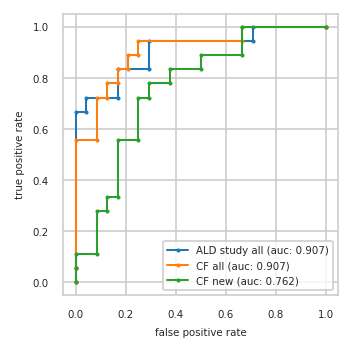

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.000 0.056
2          0.000 0.667  0.000 0.556  0.000 0.111
3          0.042 0.667  0.083 0.556  0.083 0.111
4          0.042 0.722  0.083 0.722  0.083 0.278
5          0.167 0.722  0.125 0.722  0.125 0.278
6          0.167 0.833  0.125 0.778  0.125 0.333
7          0.292 0.833  0.167 0.778  0.167 0.333
8          0.292 0.944  0.167 0.833  0.167 0.556
9          0.708 0.944  0.208 0.833  0.250 0.556
10         0.708 1.000  0.208 0.889  0.250 0.722
11         1.000 1.000  0.250 0.889  0.292 0.722
12           NaN   NaN  0.250 0.944  0.292 0.778
13           NaN   NaN  0.667 0.944  0.375 0.778
14           NaN   NaN  0.667 1.000  0.375 0.833
15           NaN   NaN  1.000 1.000  0.500 0.833
16           NaN   NaN    NaN   NaN  0.500 0.889
17           NaN   NaN    NaN   NaN  0.667 0.889
18           NaN   NaN    NaN   NaN  0.667 1.000
19           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,P31946;P31946-2,A0A087WXB8;Q9Y274,Q9UMX0;Q9UMX0-2;Q9UMX0-4
2,P02766,P02741,P31150
3,P61981,P51688,P31321
4,P04075,P04075,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
5,P14174,Q9Y2T3;Q9Y2T3-3,Q96GD0
6,Q9Y2T3;Q9Y2T3-3,P61981,Q9NUQ9
7,P00338;P00338-3,P14174,A0A075B7B8
8,P14618,Q14894,P51688


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


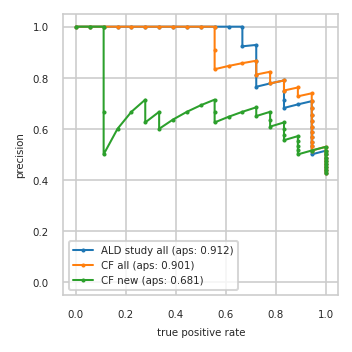

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.500 0.944     0.529 1.000     0.529 1.000
9          0.515 0.944     0.515 0.944     0.515 0.944
10         0.531 0.944     0.531 0.944     0.500 0.889
11         0.548 0.944     0.548 0.944     0.516 0.889
12         0.567 0.944     0.567 0.944     0.533 0.889
13         0.586 0.944     0.586 0.944     0.552 0.889
14         0.607 0.944     0.607 0.944     0.571 0.889
15         0.630 0.944     0.630 0.944     0.556 0.833
16         0.654 0.944     0.654 0.944     0.577 0.833
17         0.680 0.944     0.680 0.944     0.600 0.833
18         0.708 0.944     0.708 0.944     0.625 0.833
19         0.696 0.889     0.739 0.944     0.609 0.778
20         0.682 0.833     0.727 0.889     0.636 0.778
21         0.714 0.833     0.762 0.889     0.667 0.778
22         0.750 0.833     0.750 0.833     0.650 0.722
23         0.789 0.833     0.789 0.833     0.684 0.722
24         0.778 0.778     0.778 0.778     0.667 0.667
25         0.765 0.722     0.824 0.778     0.647 0.611
26         0.812 0.722     0.812 0.722     0.625 0.556
27         0.867 0.722     0.867 0.722     0.667 0.556
28         0.929 0.722     0.857 0.667     0.714 0.556
29         0.923 0.667     0.846 0.611     0.692 0.500
30         1.000 0.667     0.833 0.556     0.667 0.444
31         1.000 0.611     0.909 0.556     0.636 0.389
32         1.000 0.556     1.000 0.556     0.600 0.333
33         1.000 0.500     1.000 0.500     0.667 0.333
34         1.000 0.444     1.000 0.444     0.625 0.278
35         1.000 0.389     1.000 0.389     0.714 0.278
36         1.000 0.333     1.000 0.333     0.667 0.222
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     1.000 0.111
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


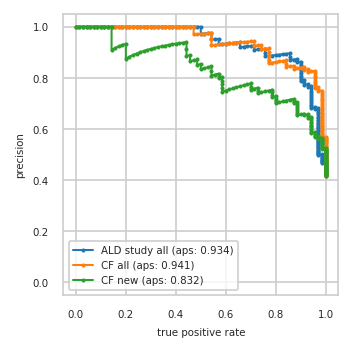

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


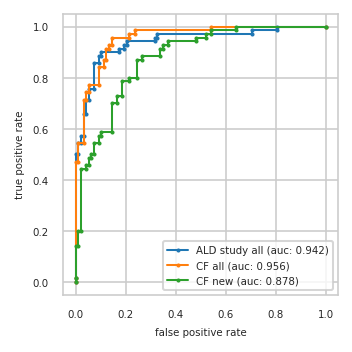

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}